# Compiler

In [41]:
from urllib.request import urlopen
import json
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

## Obtaining model and experimental data

[Cello](https://github.com/CIDARLAB/Cello-v2) is a genetic circuit compiler.
It compiles circuits written in a hardare description language (a sublanguage of `Verilog`) into
  `NOR` and `NOT` gates, to then finally generate DNA with the genetic circuit in it.
Check out the paper by [Nielsen et al.](https://www.science.org/doi/full/10.1126/science.aac7341?casa_token=s0MZasgUtiIAAAAA:hYS8PI5tJ8VqU6daoE-T3BgoOjrA_iXwvzjwFrqeUDiSA3zP5DMc6STWS7mJUZBA8x33QPrCxrvSWw) for a description of the compiler.

We will use modeling and experimental data from the Cello v2 compiler in the form of a [UCF file](https://github.com/CIDARLAB/Cello-UCF/blob/cfb4de1cf125a6fb5af1971730844ea5d0e91623/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json).
Let's load it into a variable so that we can work with it.

In [42]:
# fetch it form this url
url = "https://github.com/CIDARLAB/Cello-UCF/raw/cfb4de1cf125a6fb5af1971730844ea5d0e91623/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json"
  
# get & parse
response = urlopen(url)
ucf_data = json.loads(response.read())

# if stored locally use this:
#
# with open('Eco1C1G1T1.UCF.json','r') as f:
#     s = f.read()
# ucf_data = json.loads(s)

And check out what is inside. It is a list that starts with a header that includes general information from the used bacteria to experimental conditions under which data was obtained:

In [43]:
print(ucf_data[0])

{'collection': 'header', 'description': 'TetR homologs: PhlF, SrpR, BM3R1, HlyIIR, BetI, AmtR, AmeR, QacR, IcaRA, LitR, PsrA, LmrA', 'version': 'Eco1C1G1T1', 'date': 'Thu Dec 24 00:56:10 EST 2015', 'author': ['Bryan Der', 'Timothy Jones'], 'organism': 'Escherichia coli NEB 10-beta', 'genome': 'NEB 10 ∆(ara-leu) 7697 araD139 fhuA ∆lacX74 galK16 galE15 e14- φ80dlacZ∆M15  recA1 relA1 endA1 nupG  rpsL (StrR) rph spoT1 ∆(mrr-hsdRMS-mcrBC)', 'media': 'M9 minimal media composed of M9 media salts (6.78 g/L Na2HPO4, 3 g/L KH2PO4, 1 g/L NH4Cl, 0.5 g/L NaCl, 0.34 g/L thiamine hydrochloride, 0.4% D-glucose, 0.2% Casamino acids, 2 mM MgSO4, and 0.1 mM CaCl2; kanamycin (50 ug/ml), spectinomycin (50 ug/ml)', 'temperature': '37', 'growth': 'Inoculation: Individual colonies into M9 media, 16 hours overnight in plate shaker.  Dilution: Next day, cells dilute ~200-fold into M9 media with antibiotics, growth for 3 hours.  Induction: Cells diluted ~650-fold into M9 media with antibiotics.  Growth: shaking 

To get an overview on all the elements stored in the UCF file, let's see the collection names.

In [44]:
print([d['collection'] for d in ucf_data])

['header', 'measurement_std', 'logic_constraints', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library', 'motif_library

## A NOR gate from the library

The library contains several gates as can be seen in the `collection` variables.
Le us study one such gate: the `S3_SrpR`.


In [56]:
gates_lib = [d for d in ucf_data if d['collection'] == 'gates']

gate_name = 'S3_SrpR'  # 'L1_LitR'
gate = [g for g in gates_lib if g['name'] == gate_name][0]

print(gate)

{'collection': 'gates', 'name': 'S3_SrpR', 'system': 'TetR', 'group': 'SrpR', 'regulator': 'SrpR', 'gate_type': 'NOR', 'color': '006838', 'model': 'S3_SrpR_model', 'structure': 'S3_SrpR_structure'}


In fact all gates are `NOR` gates as we can check:

In [57]:
print( [g['gate_type'] for g in gates_lib] )

['NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR']


## Structure of the gate

It's structure, i.e., the genetic design, is obtained as follows:

In [58]:
structure_lib = [d for d in ucf_data if d['collection'] == 'structures']
structure = [s for s in structure_lib if s['name'] == gate['structure']][0]
print(structure)

{'collection': 'structures', 'name': 'S3_SrpR_structure', 'inputs': [{'name': 'in1', 'part_type': 'promoter'}, {'name': 'in2', 'part_type': 'promoter'}], 'outputs': ['pSrpR'], 'devices': [{'name': 'S3_SrpR', 'components': ['#in1', '#in2', 'S3_SrpR_cassette']}, {'name': 'S3_SrpR_cassette', 'components': ['RiboJ10', 'S3', 'SrpR', 'ECK120029600']}]}


## Model of the gate

It's model is obtained by

In [59]:
model_lib = [d for d in ucf_data if d['collection'] == 'models']
model = [m for m in model_lib if m['name'] == gate['model']][0]
print(model)

{'collection': 'models', 'name': 'S3_SrpR_model', 'functions': {'response_function': 'Hill_response', 'input_composition': 'linear_input_composition', 'toxicity': 'S3_SrpR_toxicity', 'cytometry': 'S3_SrpR_cytometry'}, 'parameters': [{'name': 'ymax', 'value': 2.1, 'description': 'Maximal transcription'}, {'name': 'ymin', 'value': 0.004, 'description': 'Minimal transcription'}, {'name': 'K', 'value': 0.06, 'description': 'Dissociation equilibrium constant'}, {'name': 'n', 'value': 2.8, 'description': 'Cooperativety'}, {'name': 'alpha', 'value': 0.3337025658634261}, {'name': 'beta', 'value': 0.09255808434135396}]}


It says that a Hill response is used as a model with the additional specification that the inputs are composed linearly. We will check this out in a second as follows:

In [60]:
functions_lib = [d for d in ucf_data if d['collection'] == 'functions']

print('The first two elments describe these theoretical models:\n')
print(functions_lib[0])
print()
print(functions_lib[1])

The first two elments describe these theoretical models:

{'collection': 'functions', 'name': 'Hill_response', 'equation': 'ymin + (ymax - ymin) / (1.0 + (x / K)^n)', 'variables': [{'name': 'x', 'map': '#//model/functions/input_composition'}], 'parameters': [{'name': 'ymax', 'map': '#//model/parameters/ymax'}, {'name': 'ymin', 'map': '#//model/parameters/ymin'}, {'name': 'K', 'map': '#//model/parameters/K'}, {'name': 'n', 'map': '#//model/parameters/n'}]}

{'collection': 'functions', 'name': 'linear_input_composition', 'equation': 'x2 + x1', 'variables': [{'name': 'x1', 'map': '#//structure/inputs/in1/model/functions/response_function'}, {'name': 'x2', 'map': '#//structure/inputs/in2/model/functions/response_function'}]}


## Measurements

Intrestingly there are even measurments that give much greater detail.
Remember that the steady state input-output behavior is **deterministic** with Hill functions.
In fact, measurments show that there is **significant noise** on output behavior.

To see this, let's look at measurements:
The measurements are (normalized) histograms of steady-state input-output measurements in terms of **Relative Promotor Units (RPUs)**.
Details are described in the [supplementary material of Nielsen et al.](https://www.science.org/doi/suppl/10.1126/science.aac7341/suppl_file/nielsen.sm.pdf).
For example, Figure S30 shows how distributions are probagated and Section VII.C.9. “gate_cytometry” states that RPUs in UCFs are measured on the same RPU scale to allow for propagation between gates.

Let's plot the response distribution for 3 inputs to such a component.

Checking if distribution: this should be 1
1.000000000000001


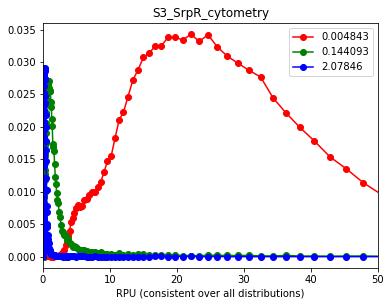

In [61]:
component = functions_lib[40]  # change to see other components: e.g. 30 for 'L1_LitR'

name = component['name']
measurements = component['table']

plt.figure(figsize=figsize)
plt.title(name)
plt.xlabel('RPU (consistent over all distributions)')

# Show some distributions
d = measurements[0]
plt.plot(d['bin'], d['output'], 'ro-', label=d['x'])

middle = int( len(measurements) / 2 )
d = measurements[middle]
plt.plot(d['bin'], d['output'], 'go-', label=d['x'])

d = measurements[-1]
plt.plot(d['bin'], d['output'], 'bo-', label=d['x'])

plt.xlim([0,50])
plt.legend()

# Let's check if the last one was really a distribution
print('Checking if distribution: this should be 1')
print(sum(d['output']))

## The simplified input-output behavior

Using what we learned in Lecture 3, we plot the steady state input-output function of the `NOR` gate.

In [62]:
# Regulation functions
def nor(x, y):
    inputs = x + y  # linear input combination
    params = {}
    for p in model['parameters']:
        params[p['name']] = np.float64(p['value'])
        print(f"{p['name']}: {p['value']}")
    
    # using linear input combination
    Hill_equation = params['ymin'] + (params['ymax'] - params['ymin']) / (1.0 + (inputs / params['K'])**params['n'])                          
    
    # uncomment to use the one from Lecture 3
    # Hill_equation = params['ymin'] + (params['ymax'] - params['ymin']) / \
    #     ( (1.0 + (x / params['K'])**params['n']) * (1.0 + (y / params['K'])**params['n']) )                      

    return Hill_equation

ymax: 2.1
ymin: 0.004
K: 0.06
n: 2.8
alpha: 0.3337025658634261
beta: 0.09255808434135396


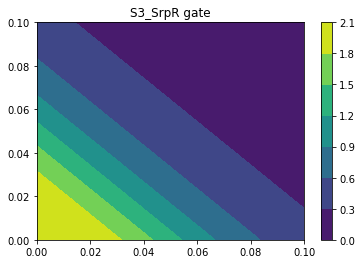

In [63]:
# this is just copied from Lecture 3
def contour_fun(x, y, z, title=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    cbar = plt.colorbar(CS)
    if title is not None:
        plt.title(title)

# Get x and y values for plotting
x = np.linspace(0, 0.1, 200)
y = np.linspace(0, 0.1, 200)
xx, yy = np.meshgrid(x, y)

# plot it
contour_fun(xx, yy,
            nor(xx, yy),
            title=f"{gate_name} gate")

## Model based on experimental data

To simplify this undertaking, we only model the expected input-output behavior.

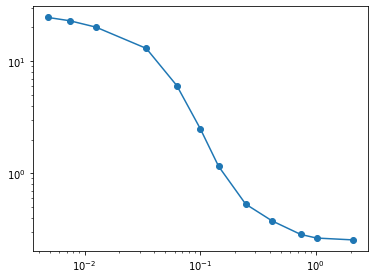

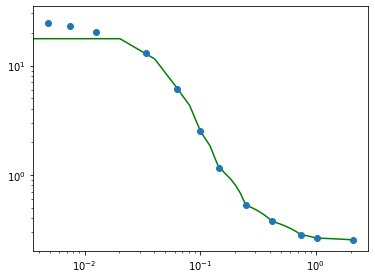

In [65]:
# compute the mean
x = []
y = []
for d in measurements:
    x += [ d['x'] ]
    y += [ np.average(d['bin'], weights=d['output']) ]
    
plt.figure(figsize=figsize)
plt.loglog(x,y,'o-')

# let's create a function from it that we can use
# we go for linear interpolation
# and enable extrapolation to be able to use it for values
# outside of the given data range
Hill_measured = interp1d(x,y, fill_value='extrapolate')

# and show it
plt.figure(figsize=figsize)
x_new = np.linspace(0,2,100)
plt.loglog(x_new, Hill_measured(x_new), 'g-')
plt.loglog(x, y, 'o')

We are now ready to use it as a `NOR` model.
Mind that we do not have experimental data on the individual inputs, so we go for the linear combination as proposed in the Cello v2 model of the `NOR`.

ymax: 4.3
ymin: 0.07
K: 0.05
n: 1.7
alpha: 0.3748404992150903
beta: 0.43564010137683185


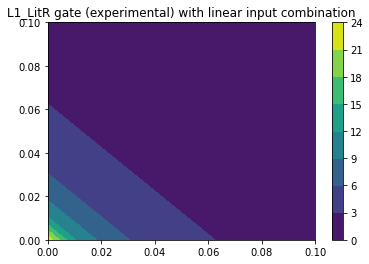

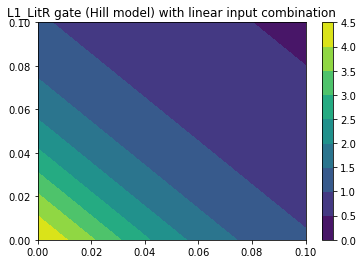

In [54]:
def nor_experimental(x, y):
    inputs = x + y  # linear input combination
    
    # using linear input combination
    Hill_equation = Hill_measured(inputs)                                              

    return Hill_equation

# Get x and y values for plotting
x = np.linspace(0, 0.1, 200)
y = np.linspace(0, 0.1, 200)
xx, yy = np.meshgrid(x, y)

# plot it
contour_fun(xx, yy,
            nor_experimental(xx, yy),
            title=f"{gate_name} gate (experimental) with linear input combination")
contour_fun(xx, yy,
            nor(xx, yy),
            title=f"{gate_name} gate (Hill model) with linear input combination")

# Tasks

1. Plot all deterministic Hill functions for all `NOR` gates in log-log plots and discuss what you see.
   You can plot them for a single input value and not two.

2. Propagate determinsitic input-output values from inputs to an output.
   Write a function that allows us to call `progagate(circuit,i)`
   where `circuit` is a linear circuit of `NOR` gates but with a single input (`INV` gates).
   The circuit may, e.g., be a `list` of `str` with `NOR` names.
   Argument `i` is an input value in RPUs.
   The output of the function is the output of the circuit in RPUs.
   
3. Do the same (1. and 2.), but with distributions as the output based on the measurements in the UCFs.
   For 1', you can take a look at `seaborn.violinplot`.
   
4. Write a compiler that, given a length of the `INV` chain, returns a "good" circuit (in the above sense).
   Explain what you chose as a criterion for "good" and why.